# MARS Behavior Classification Demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

Your MARS project directory will contain all the files created during the process of training MARS detector and pose models on your data.

If you've previously trained MARS pose models for your data, you can keep using the same directory here. Otherwise, run the cell below:

In [4]:
from create_new_project import *

location = 'C:/Users/Ryan/Documents/Kennedy Lab'
name = 'mabe_challenge'

create_new_project(location, name)

Downloading...
From: https://drive.google.com/uc?id=1NyAuwI6iQdMgRB2w4zX44yFAgEkux4op
To: C:\Users\Ryan\Documents\Kennedy Lab\mabe_challenge\MARS_v1_8_models.zip
100%|██████████| 2.41G/2.41G [09:48<00:00, 4.09MB/s]


  unzipping...
  models have been unpacked.
Project mabe_challenge created successfully.


Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

## 2. 💪 Training behavior classifiers

For now, we assume that you have already trained MARS pose estimators on your dataset, and extracted some pose data from a set of videos. Now, we're going to learn to detect behaviors in these videos!

MARS is a *supervised* classification system, meaning that it requires labeled training examples of the behaviors you would like to detect.

You can use our Matlab-based interface [Bento](https://github.com/neuroethology/bentoMAT) to create frame-by-frame manual annotations of behavioral videos- for more information see [this page](https://github.com/neuroethology/bentoMAT/wiki/Annotating-Your-Data) of the Bento wiki. (A Python version of Bento will be available soon.)

### 2.1 Assemble your videos and annotations

To train MARS behavior classifiers, you will need to add the following files to `project_path\behavior\behavior_data`:
- The raw videos you have annotated for your behavior of interest
- MARS pose estimates produced from those videos (filename ends in `_raw_pose_v###.json` (where ### is the version number of MARS))
- Your manual annotations of animals' behaviors
    - MARS currently supports annotations produced by [the Caltech Behavior Annotator](https://github.com/pdollar/toolbox/blob/master/videos/behaviorAnnotator.m) or by [Bento](https://github.com/neuroethology/bentoMAT). Support for other annotation formats will be happily added- please [contact us](mailto:ann.kennedy@northwestern.edu) with requests.

MARS uses a filename-based system for matching up videos to their corresponding pose estimates and annotations: so long as video, annotation, and pose estimates all begin with the same string, MARS will do its best to match them.

To check that all your files are found and paired up correctly, call `check_annotation_data`:

In [1]:
from behavior_classification import behavior_setup

project_path = 'D:\my_project'

behavior_setup.check_behavior_data(project_path)

Processing behavior annotations in project K:\my_project
  1 total videos found.
  all videos successfully matched with annotation and pose files!
List of behavior annotations found:
  right_turn
  omit
  left_turn


If everything seems to be in order, use `prep_behavior_data` to split your dataset into training, validation, and test sets. This takes the following optional arguments:
- `val` sets the fraction of data assigned to the validation set (defaults to 0.1, ie 10\%)
- `test` sets the fraction of data assigned to the test set (defaults to 0.2, ie 20\%)
- `reshuffle` re-assigns videos to train, validation, and test sets (defaults to `True`.)
- `drop_label` if you want to omit certain frames from your dataset, annotate them with a behavior label like 'omit', then pass that name to `drop_label`.

One particularly important optional argument:
- `cut_videos` if you have a small number of videos in your dataset, you should consider setting this to `True`; doing so will split videos into one-minute chunks of time, and shuffle these chunks into train/validation/test sets. This is not ideal for providing your final evaluation of classifier accuracy, but if you're working on iteratively improving a classifier, it can help you get started.

Three final important notes here:

- Each video in your dataset will be assigned to one set (train, validation, or test). The sizes of validation/test sets are therefore approximate- videos will be added to validation and test until at least `val`\% of frames are in the validation set and `test`\% in the test set; the remainder of videos will be assigned to the training set.
- The validation set is used to prevent overfitting to your training data, therefore you shouldn't set its size to zero.
- If the behavior you are studying is rare, you may want to manually assign files to the validation and test sets, to make sure it is adequately represented. You can do this by editing the contents of `project_path\behavior\train_test_split.yaml`. To re-generate the behavior pie graphs shown below without re-shuffling the data, call `prep_behavior_data` with optional flag `reshuffle=False`.

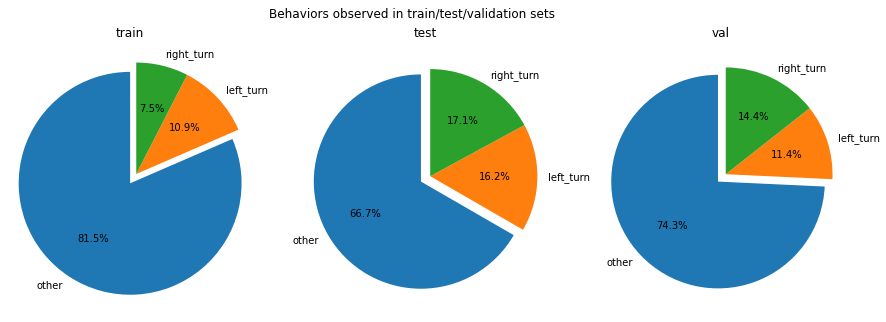

list of all observed annotations:
['left_turn', 'other', 'right_turn']


In [14]:
from behavior_classification import behavior_setup

project_path = 'D:\my_project'

behavior_setup.prep_behavior_data(project_path, cut_videos=True, drop_label='omit')

Finally, once you're happy with your splits, call `apply_clf_splits` to package data for classifier training. This script packages pose and annotation data into `.json` files, using the formatting convention established for [the CalMS21 dataset](https://data.caltech.edu/records/1991):

```json
{
    "vocabulary": {
        "other": 0,
        "(behavior_1)": 1,
        "(behavior_2)": 2
    }
    "sequences": {
        "my_project": {
            "name_of_video_1": {
                "keypoints": [],
                "bbox": [],
                "scores": [],
                "annotations": [],
                "metadata": {}
            },
            "name_of_video_2": {
                "keypoints": [],
                "bbox": [],
                "scores": [],
                "annotations": [],
                "metadata": {}        
            },
        }
    }
}
```
The `metadata` field will contain your original file paths, for safekeeping. Annotations are converted to a vector of integers, whose mapping to behavior labels is defined by the `vocabulary` dictionary.

In [1]:
from behavior_classification import behavior_setup

project_path = 'K:\my_project'

behavior_setup.apply_clf_splits(project_path)

saving train set...
saving test set...
saving val set...


### 2.2 Extract features from pose/video files

MARS extracts a set of custom-designed features from animals' poses, and uses these features to detect behaviors of interest.

Feature extraction is currently only supported for poses using the original MARS keypoint definitions (nose, ears, neck, hips, and tail, from two mice.) An update supporting more general feature extraction is in progress.

In [1]:
from behavior_classification import MARS_feature_extractor

project_path = 'C:/Users/Ryan/Documents/Kennedy Lab/mabe_challenge'

MARS_feature_extractor.extract_features(project_path)

train video 1/458: 3c8a57ba51 clip 1/1


KeyError: 'annotations'

### 2.3 Define annotation equivalences
If your training data is compiled from many old experiments, you may discover that annotators have used different names to refer to the same behavior. Or, you may want to combine multiple more fine-grained labels to create a broader behavior classifier.

MARS allows you to combine behaviors by creating `equivalences`, implemented as a python dictionary. For example, the following `equivalences` dictionary would look for any of the labels listed on the right, and use these as positive examples when training a classifier to detect the behavior `sniff_face`:

```
equivalences = {'sniff_face': ['sniffface', 'sniff-face', 'sniff_face', 'head-investigation','facesniffing']}
```

You can define `equivalences` for your project using the `set_equivalences` function. If you don't call this function, MARS will only look for annotations that match your target behavior exactly.

In [ ]:
from behavior_classification import behavior_setup

equivalences = {'sniff_face':     ['sniffface', 'snifface', 'sniff-face', 'sniff_face',
                                   'head-investigation','facesniffing'],
            'sniff_genital':      ['sniffurogenital','sniffgenitals','sniff_genitals',
                                   'sniff-genital','sniff_genital','anogen-investigation'],
            'sniff_body':         ['sniff_body','sniffbody','bodysniffing','body-investigation',
                                   'socialgrooming','sniff-body','closeinvestigate',
                                   'closeinvestigation','investigation'],
            'investigation':      ['sniffface', 'snifface', 'sniff-face', 'sniff_face',
                                   'head-investigation','facesniffing','sniffurogenital',
                                   'sniffgenitals','sniff_genitals','sniff-genital',
                                   'sniff_genital','anogen-investigation','sniff_body',
                                   'sniffbody', 'bodysniffing', 'body-investigation',
                                   'socialgrooming','sniff-body', 'closeinvestigate',
                                   'closeinvestigation', 'investigation','investigate',
                                   'first_inv','aggressive_investigation','attack_attempt',
                                   'mount_attempt','dom_mount_attempt'],
            'mount':              ['mount','aggressivemount','intromission','dom_mount','ejaculate'],
            'attack':             ['attack','attempted_attack','chase']}


project_path = 'D:\my_project'

behavior_setup.set_equivalences(project_path, equivalences)

### 2.4 Train your behavior classifier!

Finally, you can use the following command to train a new MARS classifier for a specified behavior of interest. MARS will check the `equivalences` you defined above; if it finds the specified behavior among the dictionary keys, it will include all corresponding entries associated with that key when defining positive examples of that behavior.

`train_classifier` takes a list of behaviors you want to train classifiers for, plus one optional argument:
- `drop_behaviors` will omit all frames with the listed annotation(s) from the training set. You can use this to exclude portions of a video (eg where behavior hasn't been annotated or the experimenter's hand is in the cage) from training.

In [1]:
from behavior_classification import MARS_train_test

project_path = 'C:/Users/Ryan/Documents/Kennedy Lab/mabe_challenge'

results = MARS_train_test.train_classifier(project_path, ['attack','investigation','mount', 'other'])

loading training data...


sorting features and applying filters...


Filtering sequence 70/70  100% --  [Elapsed Time: 1:18:00] |#| (Time: 1:18:00) 


MemoryError: Unable to allocate 29.1 GiB for an array with shape (507738, 7680) and data type float64

### 2.5 Evaluate classifier performance on a held-out test set

Finally, you can test the performance of your trained classifier on a test set of videos. Performance is reported in terms of the classifier **Precision** and **Recall**, defined as:
$$\textrm{Precision} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$
$$ $$
$$\textrm{Recall} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$

In [ ]:
from behavior_classification import MARS_train_test

project_path = 'D:\my_project'

MARS_train_test.test_classifier(project_path, ['attack','investigation','mount'])

If you're not happy with classifier performance, you can use Bento to manually correct errors in MARS predictions on other (non-test) videos to increase the size of your training set. You may also want to experiment with adjusting classifier parameters- this can be done by editing classifier settings in `project/behavior/config_classifiers.yaml`.

### 2.6 Deploy your trained behavior model

This is the last step, you just need to copy your classifier into your MARS end-user directory.

Specifcially, copy the contents of `my_project\behavior\trained_classifiers` to your end-user version of MARS, in `mars_v1_8\models\classifier`. To run MARS using the new models, either modify the default value of `classifier_model` in `mars_v1_8\config.yml`, or specify the model paths during runtime.